In [13]:
import os
import zipfile
import shutil

In [14]:
import os
from PIL import Image  # For handling image formats

def check_and_print_non_jpg_images(data_dir):
  """
  checks image formats,
  and prints the paths of non-JPG/JPEG images.
  """
  skipped = 0
  total = 0
  for root, _, files in os.walk(data_dir):
    for filename in files:
      ext = os.path.splitext(filename)[1].lower()
      total += 1
      # Chk valid JPG/JPEG extensions
      if ext not in (".jpg", ".jpeg", ".png"):
        image_path = os.path.join(root, filename)
        print(f"Non-JPG/JPEG image: {image_path}")
        skipped += 1
    return (total, skipped)


data_dir = "D:\\archive\\Fashion\\tshirt"
total, skp = check_and_print_non_jpg_images(data_dir)
print(f"Total files: {total}")
print(f"skipped files: {skp}")


Total files: 1991
skipped files: 0


# HELPER CODE

In [1]:
import os
import numpy as np
from PIL import Image


def folder_specs(dir_path):
    file_sizes = []
    image_dimensions = []
    file_types = {}

    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            file_sizes.append(size)

            ext = os.path.splitext(filename)[1].lower()
            file_types[ext] = file_types.get(ext, 0) + 1
            
            try:
                with Image.open(file_path) as img:
                    width, height = img.size
                    image_dimensions.append((width, height))
            except Exception as e:
                print(f"Could not open image {filename}: {e}")

    num_elements = len(file_sizes)
    max_file_size = max(file_sizes) if file_sizes else 0
    min_file_size = min(file_sizes) if file_sizes else 0
    median_file_size = np.median(file_sizes) if file_sizes else 0

    if image_dimensions:
        max_image_dim = max(image_dimensions, key=lambda x: x[0] * x[1])
        min_image_dim = min(image_dimensions, key=lambda x: x[0] * x[1])
    else:
        max_image_dim = min_image_dim = (0, 0)

    print(f'Number of elements: {num_elements}')
    print(f'File types and counts: {file_types}')
    print(f'Max file size: {max_file_size} bytes')
    print(f'Min file size: {min_file_size} bytes')
    print(f'Median file size: {median_file_size} bytes')
    print(f'Max image dimension (width x height): {max_image_dim}')
    print(f'Min image dimension (width x height): {min_image_dim}')



In [27]:
import os
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

def process_images(input_dir, output_dir, target_size=(768, 768)):
    
    os.makedirs(output_dir, exist_ok=True)
    transform_rgb = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


    for image_name in os.listdir(input_dir):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            #Open image and convert to RGB
            img = Image.open(os.path.join(input_dir, image_name)).convert('RGB')
            img = img.resize(target_size, Image.BICUBIC)
            image_tensor = transform_rgb(img)
            
            # Convert back to PIL Image
            processed_img = transforms.ToPILImage()(image_tensor)
            
            # Save as JPG
            output_path = os.path.join(output_dir, f'processed_{os.path.splitext(image_name)[0]}.jpg')
            processed_img.save(output_path, 'JPEG', quality=95)


From here on, the folder is divided in two parts. One with humans (shirts to be segmented) included, others with no without models(bg removal)

# Shirt Images to be segmented

In [17]:
dir_path = 'D:\\input_images'
folder_specs(dir_path=dir_path)

Number of elements: 766
File types and counts: {'.jpg': 766}
Max file size: 82342 bytes
Min file size: 10749 bytes
Median file size: 30823.0 bytes
Max image dimension (width x height): (513, 657)
Min image dimension (width x height): (513, 655)


THE CODE UNDER IS OUTSOURCED

In [ ]:
# @title Setup Environment and Download Resources
%cd /content/
!rm -rf cloth-segmentation
!git clone https://github.com/ozzy404/cloth-segmentation.git
%cd cloth-segmentation
!gdown --id 1mhF3yqd7R-Uje092eypktNl-RoZNuiCJ
!mkdir input_images
!mkdir output_images

# @title Download model
!pip install gdown

import gdown
file_id = '1aS4gB2UucK1twuU5ROg_MYRIxm3jmk1v'
url = f'https://drive.google.com/uc?id={file_id}'

# Download file
output = 'cloth_segm_u2net_latest.pth'
gdown.download(url, output, quiet=False)

print(f'File uploaded as {output}')


# @title Upload input images in input_images folder.
# @markdown Importantly, running this code again will delete all previous photos, so load the previous processing result before running it.

import os
import shutil
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from google.colab import files
import io
import matplotlib.pyplot as plt
import cv2  # Import OpenCV for dilation

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu
from networks import U2NET

device = 'cpu'

# Create directories if they don't exist
image_dir = '/content/cloth-segmentation/input_images'
result_dir = '/content/cloth-segmentation/output_images'
checkpoint_path = '/content/cloth-segmentation/cloth_segm_u2net_latest.pth'

if not os.path.exists(image_dir):
    os.makedirs(image_dir)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Clear output directory before processing
for file in os.listdir(result_dir):
    file_path = os.path.join(result_dir, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

# Clear input directory before uploading new images
for file in os.listdir(image_dir):
    file_path = os.path.join(image_dir, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask. """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    return palette

transforms_list = [transforms.ToTensor(), Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

net = U2NET(in_ch=3, out_ch=4)

def load_checkpoint_mgpu(model, checkpoint_path):
    """ Load checkpoint for multi-GPU training """
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Load state dict
    model.load_state_dict(checkpoint.get('state_dict', checkpoint), strict=False)
    return model

net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net = net.eval()

palette = get_palette(4)

# Upload images
uploaded = files.upload()
for filename, file in uploaded.items():
    with open(os.path.join(image_dir, filename), 'wb') as f:
        f.write(file)

# Process images
images_list = sorted(os.listdir(image_dir))
pbar = tqdm(total=len(images_list))

for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert('RGB')
    img_size = img.size
    img = img.resize((768, 768), Image.BICUBIC)
    image_tensor = transform_rgb(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)

    output_tensor = net(image_tensor.to(device))
    output_tensor = F.log_softmax(output_tensor[0], dim=1)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_arr = output_tensor.cpu().numpy()

  
    shirt_mask = (output_arr == 1).astype(np.uint8) 


    shirt_mask = cv2.resize(shirt_mask, img_size, interpolation=cv2.INTER_NEAREST)


    img_np = np.array(img.resize(img_size))
    shirt_img = cv2.bitwise_and(img_np, img_np, mask=shirt_mask)

    shirt_img_rgba = cv2.cvtColor(shirt_img, cv2.COLOR_RGB2RGBA)
    shirt_img_rgba[:, :, 3] = shirt_mask * 255  


    output_img_path = os.path.join(result_dir, image_name[:-4] + '_shirt.png')
    Image.fromarray(shirt_img_rgba).save(output_img_path)

    # Display the extracted shirt
    plt.imshow(shirt_img_rgba)
    plt.title(f'Extracted Shirt: {image_name}')
    plt.axis('off')
    plt.show()

    pbar.update(1)

pbar.close()


# @title Download results from output_images

import os
from google.colab import files

# Function to download files
def download_files_from_folder(folder_path):
    # Get the list of all files in the folder
    files_list = os.listdir(folder_path)

    # Filter files, keeping only images
    image_files = [f for f in files_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    for image_file in image_files:
        # Path to the image
        file_path = os.path.join(folder_path, image_file)
        # Download the file
        files.download(file_path)

# Specify the path to the folder with images
folder_path = 'output_images'
download_files_from_folder(folder_path)

THE FOLDER WAS DOWNLOADED AND BAD DATA WAS FILTERED MANUALLY

* Before Normalization

In [18]:
dir_path = 'C:\\Users\\ASUS\\Downloads\\cloth-segmentation\\output_images'
folder_specs(dir_path=dir_path)

Number of elements: 766
File types and counts: {'.png': 766}
Max file size: 394075 bytes
Min file size: 1383 bytes
Median file size: 113711.5 bytes
Max image dimension (width x height): (513, 657)
Min image dimension (width x height): (513, 655)


In [24]:
import os
import numpy as np
from PIL import Image
from scipy import ndimage
from collections import Counter

def get_most_common_edge_color(image, edge_width=5):
    # Convert to numpy array
    img_array = np.array(image)
    
    # Create a mask for the non-background pixels
    if img_array.shape[2] == 4:
        mask = img_array[:,:,3] > 0
    else:
        mask = np.any(img_array[:,:,:3] < 255, axis=2)
    
    # Erode the mask to get the edge
    edge_mask = mask ^ ndimage.binary_erosion(mask, iterations=edge_width)
    
    # Get the colors of the edge pixels
    edge_colors = img_array[edge_mask][:,:3]
    
    # Find the most common color
    color_counts = Counter(map(tuple, edge_colors))
    most_common_color = color_counts.most_common(1)[0][0]
    
    return most_common_color

def smooth_edges(image, iterations=5):
    edge_color = get_most_common_edge_color(image)
    img_array = np.array(image)
    
    # Create alpha mask
    if img_array.shape[2] == 4:  # RGBA
        alpha = img_array[:,:,3] > 0
    else:  # RGB
        # Assume white background
        alpha = np.any(img_array[:,:,:3] < 255, axis=2)
    
    # Dilate and erode to smooth edges
    smoothed_alpha = ndimage.binary_dilation(alpha, iterations=iterations)
    smoothed_alpha = ndimage.binary_erosion(smoothed_alpha, iterations=iterations)
    
    # Create new image array
    if img_array.shape[2] == 4:  # RGBA
        smoothed_array = np.zeros_like(img_array)
        smoothed_array[:,:,:3] = edge_color
        smoothed_array[:,:,3] = smoothed_alpha * 255
    else:  # RGB
        smoothed_array = np.full_like(img_array, 255) 
        smoothed_array[smoothed_alpha] = edge_color
    
    result = np.where(np.expand_dims(alpha, 2), img_array, smoothed_array)
    
    return Image.fromarray(result.astype(np.uint8))

def pad_image(image, size=(768, 768)):
    padded_image = Image.new('RGB', size, (255, 255, 255))
    
    # Calculate position to paste original image
    paste_pos = ((size[0] - image.width) // 2, (size[1] - image.height) // 2)
    
    if image.mode == 'RGBA':
        
        padded_image.paste(image, paste_pos, image.split()[3])
    else:
        padded_image.paste(image, paste_pos)
    
    return padded_image

# def pad_image(image, size=(768, 768)):
#     # Create a new image with the desired size and transparent background
#     padded_image = Image.new('RGBA', size, (0, 0, 0, 0))
    
#     # Calculate position to paste original image
#     paste_pos = ((size[0] - image.width) // 2, (size[1] - image.height) // 2)
    
#     # Ensure the image has an alpha channel
#     if image.mode != 'RGBA':
#         image = image.convert('RGBA')
    
#     # Paste original image onto padded image
#     padded_image.paste(image, paste_pos, image)
    
#     return padded_image

def process_image(file_path):

    image = Image.open(file_path)
    smoothed = smooth_edges(image)
    padded = pad_image(smoothed)
    
    return padded

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    

    for filename in os.listdir(input_folder):
        if filename.lower().endswith('.png'):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            
            processed_image = process_image(input_path)
            processed_image.save(output_path)
            print(f"Processed: {filename}")

# Usage
input_folder = r'C:\Users\ASUS\Downloads\cloth-segmentation\Final-segmented-shirts'
output_folder = r'C:\Users\ASUS\Downloads\cloth-segmentation\processed-shirts'
process_folder(input_folder, output_folder)

Processed: 102_shirt.png
Processed: 103_shirt.png
Processed: 106_shirt.png
Processed: 107_shirt.png
Processed: 108_shirt.png
Processed: 109_shirt.png
Processed: 111_shirt.png
Processed: 112_shirt.png
Processed: 119_shirt.png
Processed: 11_shirt.png
Processed: 120_shirt.png
Processed: 123_shirt.png
Processed: 124_shirt.png
Processed: 127_shirt.png
Processed: 129_shirt.png
Processed: 12_shirt.png
Processed: 134_shirt.png
Processed: 135_shirt.png
Processed: 138_shirt.png
Processed: 141_shirt.png
Processed: 142_shirt.png
Processed: 144_shirt.png
Processed: 146_shirt.png
Processed: 147_shirt.png
Processed: 152_shirt.png
Processed: 154_shirt.png
Processed: 159_shirt.png
Processed: 15_shirt.png
Processed: 160_shirt.png
Processed: 161_shirt.png
Processed: 162_shirt.png
Processed: 163_shirt.png
Processed: 164_shirt.png
Processed: 16_shirt.png
Processed: 170_shirt.png
Processed: 178_shirt.png
Processed: 179_shirt.png
Processed: 182_shirt.png
Processed: 183_shirt.png
Processed: 187_shirt.png
Proc

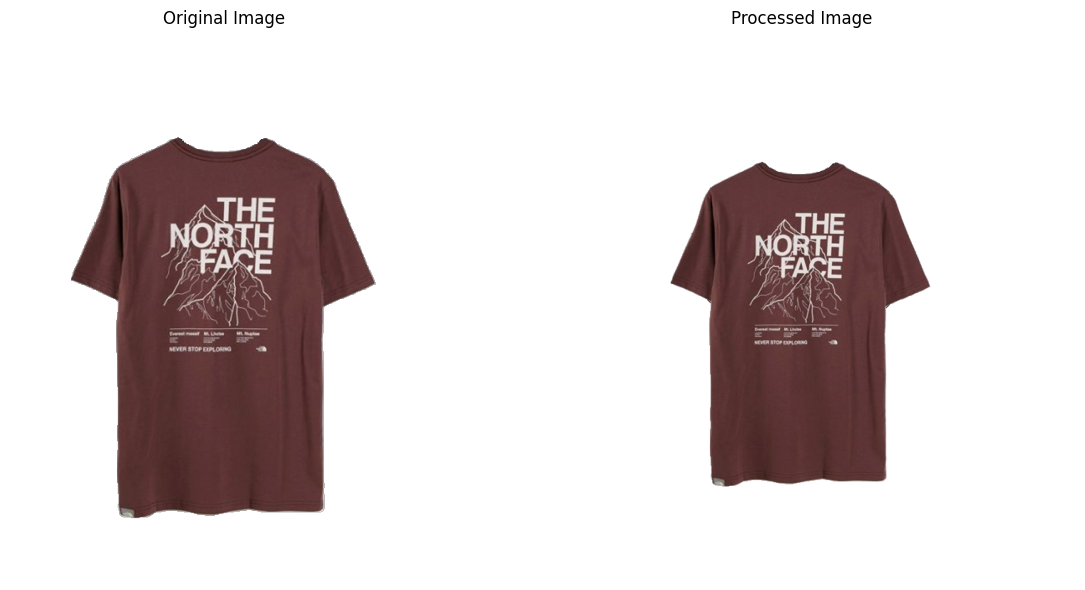

Original image size: (513, 655)
Processed image size: (768, 768)


In [25]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def compare_images(input_folder, output_folder, image_name):

    input_path = os.path.join(input_folder, image_name)
    output_path = os.path.join(output_folder, image_name)
    

    input_image = Image.open(input_path)
    output_image = Image.open(output_path)
    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(input_image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    

    ax2.imshow(output_image)
    ax2.set_title('Processed Image')
    ax2.axis('off')
    

    plt.tight_layout()
    plt.show()

    print(f"Original image size: {input_image.size}")
    print(f"Processed image size: {output_image.size}")

# Folder paths
input_folder = r'C:\Users\ASUS\Downloads\cloth-segmentation\Final-segmented-shirts'
output_folder = r'C:\Users\ASUS\Downloads\cloth-segmentation\processed-shirts'


image_name = '30_shirt.png'
compare_images(input_folder, output_folder, image_name)

In [26]:
dir_path = r'C:\Users\ASUS\Downloads\cloth-segmentation\processed-shirts'
folder_specs(dir_path=dir_path)

Number of elements: 384
File types and counts: {'.png': 384}
Max file size: 368978 bytes
Min file size: 42037 bytes
Median file size: 111836.0 bytes
Max image dimension (width x height): (768, 768)
Min image dimension (width x height): (768, 768)


* After

In [29]:
input_directory = r'C:\Users\ASUS\Downloads\cloth-segmentation\processed-shirts'
output_directory = 'D://final_processed_shirt_data'
process_images(input_directory, output_directory)

dir_path = r'C:\Users\ASUS\Downloads\cloth-segmentation\processed-shirts'
folder_specs(dir_path=dir_path)

Number of elements: 384
File types and counts: {'.png': 384}
Max file size: 368978 bytes
Min file size: 42037 bytes
Median file size: 111836.0 bytes
Max image dimension (width x height): (768, 768)
Min image dimension (width x height): (768, 768)


# Clear Shirt Images

In [40]:
dir_path = 'D://simple_images'
folder_specs(dir_path=dir_path)

Number of elements: 1225
File types and counts: {'.jpg': 1225}
Max file size: 972685 bytes
Min file size: 58535 bytes
Median file size: 250704.0 bytes
Max image dimension (width x height): (2000, 2667)
Min image dimension (width x height): (2000, 2666)


In [41]:
input_directory = 'D://simple_images'
output_directory = 'D://final_shirt_data'
process_images(input_directory, output_directory)

After

In [44]:
dir_path = 'D://final_shirt_data'
folder_specs(dir_path=dir_path)

Number of elements: 1225
File types and counts: {'.jpg': 1225}
Max file size: 369800 bytes
Min file size: 43958 bytes
Median file size: 134936.0 bytes
Max image dimension (width x height): (768, 768)
Min image dimension (width x height): (768, 768)


### **Total Shirt Data**
(Manually merged)

In [31]:

dir_path = r'D:\training-shirt-data'
folder_specs(dir_path=dir_path)

Number of elements: 1609
File types and counts: {'.jpg': 1609}
Max file size: 369800 bytes
Min file size: 24760 bytes
Median file size: 126547.0 bytes
Max image dimension (width x height): (768, 768)
Min image dimension (width x height): (768, 768)


# **ART DATA**

In [43]:
dir_path = 'C:\\Users\\ASUS\\Downloads\\art_images'
folder_specs(dir_path=dir_path)

output_directory = 'D://final_art_data'
process_images(dir_path, output_directory)

Number of elements: 622
File types and counts: {'.jpg': 622}
Max file size: 2142659 bytes
Min file size: 11562 bytes
Median file size: 110539.0 bytes
Max image dimension (width x height): (3000, 1488)
Min image dimension (width x height): (103, 130)


* After Processing

In [2]:
output_directory = 'D://final_art_data'
folder_specs(dir_path=output_directory)

Number of elements: 622
File types and counts: {'.jpg': 622}
Max file size: 676566 bytes
Min file size: 73644 bytes
Median file size: 359272.0 bytes
Max image dimension (width x height): (768, 768)
Min image dimension (width x height): (768, 768)


* Total Shirt Data

In [3]:
output_directory = r'D:\training-shirt-data'
folder_specs(dir_path=output_directory)

Number of elements: 1609
File types and counts: {'.jpg': 1609}
Max file size: 369800 bytes
Min file size: 24760 bytes
Median file size: 126547.0 bytes
Max image dimension (width x height): (768, 768)
Min image dimension (width x height): (768, 768)


# Local Segmentation

In [3]:
import os
import shutil
import subprocess
import sys

def run_command(command):
    try:
        result = subprocess.run(command, check=True, capture_output=True, text=True)
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {' '.join(command)}")
        print(f"Error message: {e.stderr}")
        return False
    return True

# Set working directory
os.chdir(os.getcwd())

# Remove previous cloth-segmentation folder if it exists
shutil.rmtree('cloth-segmentation', ignore_errors=True)

# Clone the repo
if not run_command(['git', 'clone', 'https://github.com/ozzy404/cloth-segmentation.git']):
    print("Failed to clone the repository. Please check if the repository still exists or if you have network issues.")
    sys.exit(1)

# Change to the cloned directory
os.chdir('cloth-segmentation')

# Download resource file using gdown
if not run_command(['gdown', '--id', '1mhF3yqd7R-Uje092eypktNl-RoZNuiCJ']):
    print("Failed to download the resource file. Please check your internet connection or if gdown is installed.")
    sys.exit(1)

# Create input and output directories
os.makedirs('input_images', exist_ok=True)
os.makedirs('output_images', exist_ok=True)

print("Setup completed successfully!")


Error executing command: gdown --id 1mhF3yqd7R-Uje092eypktNl-RoZNuiCJ
Error message: C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1mhF3yqd7R-Uje092eypktNl-RoZNuiCJ

but Gdown can't. Please check connections and permissions.

Failed to download the resource file. Please check your internet connection or if gdown is installed.


SystemExit: 1

In [5]:
import gdown
import os
import shutil
import subprocess
import sys

# Install gdown if not already installed
subprocess.run(['pip', 'install', 'gdown'], check=True)

# Download model checkpoint
file_id = '1aS4gB2UucK1twuU5ROg_MYRIxm3jmk1v'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'cloth_segm_u2net_latest.pth'
gdown.download(url, output, quiet=False)

print(f'File downloaded as {output}')


Downloading...
From (original): https://drive.google.com/uc?id=1aS4gB2UucK1twuU5ROg_MYRIxm3jmk1v
From (redirected): https://drive.google.com/uc?id=1aS4gB2UucK1twuU5ROg_MYRIxm3jmk1v&confirm=t&uuid=d1dff2d3-d036-4c13-8a11-3025ccfce003
To: c:\Users\ASUS\Downloads\cloth_segm_u2net_latest.pth
100%|██████████| 177M/177M [01:14<00:00, 2.36MB/s] 


File downloaded as cloth_segm_u2net_latest.pth


# localized u2net

In [ ]:
import torch
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm

from data.base_dataset import Normalize_image
from utils.saving_utils import load_checkpoint_mgpu
from networks import U2NET

# Define helper functions and transformations
def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask. """
    palette = [0] * (num_cls * 3)
    for j in range(0, num_cls):
        lab = j
        for i in range(8):
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            lab >>= 3
    return palette

# Define transforms
transforms_list = [transforms.ToTensor(), Normalize_image(0.5, 0.5)]
transform_rgb = transforms.Compose(transforms_list)

# Load model
net = U2NET(in_ch=3, out_ch=4)

def load_checkpoint_mgpu(model, checkpoint_path):
    """ Load checkpoint for multi-GPU training """
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint.get('state_dict', checkpoint), strict=False)
    return model

# Load and set up model
checkpoint_path = './cloth-segmentation/cloth_segm_u2net_latest.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = load_checkpoint_mgpu(net, checkpoint_path)
net = net.to(device)
net.eval()

# Set input and output directories
image_dir = './cloth-segmentation/input_images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

result_dir = './cloth-segmentation/output_images'
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

palette = get_palette(4)

# Load and process images
images_list = sorted(os.listdir(image_dir))
pbar = tqdm(total=len(images_list))

for image_name in images_list:
    img = Image.open(os.path.join(image_dir, image_name)).convert('RGB')
    img_size = img.size
    img = img.resize((768, 768), Image.BICUBIC)
    image_tensor = transform_rgb(img)
    image_tensor = torch.unsqueeze(image_tensor, 0)

    output_tensor = net(image_tensor.to(device))
    output_tensor = F.log_softmax(output_tensor[0], dim=1)
    output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_tensor = torch.squeeze(output_tensor, dim=0)
    output_arr = output_tensor.cpu().numpy()

    # Create mask for shirt extraction
    shirt_mask = (output_arr == 1).astype(np.uint8)  # Assuming label 1 corresponds to the shirt

    # Ensure that shirt_mask is not empty before resizing
    print(img.size, shirt_mask.size)
    if shirt_mask.size == 0:
        print(f"Skipping {image_name}: shirt mask is empty.")
        continue

    # Resize mask to original image size only if non-empty

    shirt_mask = cv2.resize(shirt_mask, img_size, interpolation=cv2.INTER_NEAREST)
    print(shirt_mask.size)
    # Extract shirt from original image using the mask
    img_np = np.array(img.resize(img_size))
    shirt_img = cv2.bitwise_and(img_np, img_np, mask=shirt_mask)

    # Convert to RGBA for transparency
    shirt_img_rgba = cv2.cvtColor(shirt_img, cv2.COLOR_RGB2RGBA)
    shirt_img_rgba[:, :, 3] = shirt_mask * 255  # Set alpha channel to mask

    # Save the shirt image
    output_img_path = os.path.join(result_dir, image_name[:-4] + '_shirt.png')
    Image.fromarray(shirt_img_rgba).save(output_img_path)

    # Display the extracted shirt
    plt.imshow(shirt_img_rgba)
    plt.title(f'Extracted Shirt: {image_name}')
    plt.axis('off')
    plt.show()

    pbar.update(1)

pbar.close()


In [9]:
# import torch
# import os
# import numpy as np
# from PIL import Image
# import cv2
# import matplotlib.pyplot as plt
# from torchvision import transforms
# import torch.nn.functional as F
# from tqdm import tqdm

# from data.base_dataset import Normalize_image
# from utils.saving_utils import load_checkpoint_mgpu
# from networks import U2NET

# def get_palette(num_cls):
#     """ Returns the color map for visualizing the segmentation mask. """
#     n = num_cls
#     palette = [0] * (n * 3)
#     for j in range(0, n):
#         lab = j
#         palette[j * 3 + 0] = 0
#         palette[j * 3 + 1] = 0
#         palette[j * 3 + 2] = 0
#         i = 0
#         while lab:
#             palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
#             palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
#             palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
#             i += 1
#             lab >>= 3
#     return palette

# # Define device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Setup the transformation
# transforms_list = [transforms.ToTensor(), Normalize_image(0.5, 0.5)]
# transform_rgb = transforms.Compose(transforms_list)

# # Initialize network
# net = U2NET(in_ch=3, out_ch=4)

# # Load the model checkpoint
# checkpoint_path = './cloth-segmentation/cloth_segm_u2net_latest.pth'  # Update with the correct path
# net = load_checkpoint_mgpu(net, checkpoint_path)
# net = net.to('cpu')
# net = net.eval()

# palette = get_palette(4)
# # Set input and output directories
# image_dir = './input_images'
# if not os.path.exists(image_dir):
#     os.makedirs(image_dir)

# result_dir = './output_images'
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)

# # Upload and process images
# images_list = sorted(os.listdir(image_dir))
# pbar = tqdm(total=len(images_list))

# for image_name in images_list:
#     img = Image.open(os.path.join(image_dir, image_name)).convert('RGB')
#     img_size = img.size
#     img = img.resize((768, 768), Image.BICUBIC)
#     image_tensor = transform_rgb(img)
#     image_tensor = torch.unsqueeze(image_tensor, 0)

#     # Model inference
#     output_tensor = net(image_tensor.to(device))
#     output_tensor = F.log_softmax(output_tensor[0], dim=1)
#     output_tensor = torch.max(output_tensor, dim=1, keepdim=True)[1]
#     output_tensor = torch.squeeze(output_tensor, dim=0)
#     output_tensor = torch.squeeze(output_tensor, dim=0)
#     output_arr = output_tensor.cpu().numpy()

#     # Extract shirt mask
#     shirt_mask = (output_arr == 1).astype(np.uint8)

#     # Resize mask to original image size
#     shirt_mask = cv2.resize(shirt_mask, img_size, interpolation=cv2.INTER_NEAREST)

#     # Extract shirt from original image using the mask
#     img_np = np.array(img.resize(img_size))
#     shirt_img = cv2.bitwise_and(img_np, img_np, mask=shirt_mask)

#     # Convert to RGBA for transparency (white background)
#     shirt_img_rgba = cv2.cvtColor(shirt_img, cv2.COLOR_RGB2RGBA)
#     shirt_img_rgba[:, :, 3] = shirt_mask * 255

#     # Save the extracted shirt image
#     output_img_path = os.path.join(result_dir, image_name[:-4] + '_shirt.png')
#     Image.fromarray(shirt_img_rgba).save(output_img_path)

#     # Display the extracted shirt
#     plt.imshow(shirt_img_rgba)
#     plt.title(f'Extracted Shirt: {image_name}')
#     plt.axis('off')
#     plt.show()

#     pbar.update(1)

# pbar.close()


In [ ]:
import os
import torch
from PIL import Image
import numpy as np
from torchvision import transforms

def create_6_channel_image(shirt_path, art_path, output_path):
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize to 256x256
        transforms.ToTensor(),            # Convert to tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
    ])

    # Load and transform shirt and art images
    shirt_img = Image.open(shirt_path).convert('RGB')
    art_img = Image.open(art_path).convert('RGB')

    # Apply transformations
    shirt_tensor = transform(shirt_img)
    art_tensor = transform(art_img)

    # Concatenate images along channel dimension (6 channels)
    combined_input = torch.cat([shirt_tensor, art_tensor], dim=0)  # Shape: (6, 256, 256)

    # Convert the tensor back to a numpy array for saving
    combined_image_np = combined_input.numpy()

    # Normalize the channels for visualization (0-255 range)
    combined_image_np -= combined_image_np.min(axis=(1, 2), keepdims=True)
    combined_image_np /= combined_image_np.max(axis=(1, 2), keepdims=True)
    combined_image_np *= 255

    # Convert to uint8
    combined_image_np = combined_image_np.astype(np.uint8)

    # Save the 6-channel image as a multi-page TIFF file
    Image.fromarray(combined_image_np[0:3], mode='RGB').save(output_path, save_all=True,
        append_images=[Image.fromarray(combined_image_np[i], mode='L') for i in range(3, 6)])

if __name__ == "__main__":
    shirt_image_path = 'a1.jpg'  # Update with your shirt image path
    art_image_path = 's3.jpg'      # Update with your art image path
    output_image_path = 'output_6_channel.tiff'   # Output path for the 6-channel image
    
    create_6_channel_image(shirt_image_path, art_image_path, output_image_path)